In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim

from torchtext.data import Field, BucketIterator, TabularDataset, BucketIterator,Example

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
import pandas as pd

import random
import math
import time
import os

path = '/home/edshkim98/nlp/classification/bbc/' #location of dataset
source_folder = '/home/edshkim98/nlp/classification/' #location of code file
destination_folder = source_folder+'pretrained' #location of saved pretrained model

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import glob

In [3]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [4]:
data = path+'/News Articles/'
data2 = path+'/Summaries/'

os.listdir(data)

['business', 'tech', 'politics', 'sport', 'entertainment']

In [5]:
#Dont use summary data, cuz it's unfair
all_files = glob.glob(data+'*/*')#+glob.glob(data+'*/*')
len(all_files)

2225

In [6]:
summaries = glob.glob(data2+'*/*')

In [7]:
labels = {"business":0,"tech":1, "politics":2, "sport":3, "entertainment":4}

In [8]:
all_files[1000].split('/')[-2]

'politics'

In [ ]:
all_data = []
for i in range(len(all_files)):
    #print(i)
    with open(all_files[i], encoding='latin1') as f:
        lines = f.readlines()
        lines = [line[:-1] for line in lines if line != '\n']
        lines = ' '.join(lines)
    label = labels[all_files[i].split('/')[-2]]
    all_data.append([lines,label])

In [ ]:
summaries_data = []
for i in range(len(summaries)):
    #print(i)
    with open(summaries[i], encoding='latin1') as f:
        lines = f.readlines()
        lines = [line[:-1] for line in lines if line != '\n']
        lines = ' '.join(lines)
    label = labels[summaries[i].split('/')[-2]]
    summaries_data.append([lines,label])
summaries_data[0]

In [11]:
all_data[0]

["India's Maruti sees profits jump India's biggest carmaker Maruti has reported a sharp increase in quarterly profit after a booming economy and low interest rates boosted demand. Net profit surged 70% to 2.39bn rupees ($54.98m; Â£29.32m) in the last three months of 2004 compared with 1.41bn rupees a year earlier. Total sales were 30.1bn rupees, up 27% from the same 2004 period. Maruti accounts for half of India's domestic car sales, luring consumers with cheap, fuel-efficient vehicles. Demand in India also has been driven by the poor state of public transport and the very low level of car ownership, analysts said. Figures show that only eight people per thousand are car owners. Maruti beat market expectations despite an increase in raw materials costs. The company, majority-owned by Japan's Suzuki, said an increase in steel and other raw material prices was partially offset by cost cutting. Sales in the fiscal third quarter, including vans and utility vehicles, rose by 17.8% to 136.06

In [12]:
data = pd.DataFrame({"label": [i[1] for i in all_data], "text": [i[0] for i in all_data]})

In [13]:
data

,label,text
0,0,India's Maruti sees profits jump India's bigge...
1,0,Mixed Christmas for US retailers US retailers ...
2,0,Rank 'set to sell off film unit' Leisure group...
3,0,Qatar and Shell in $6bn gas deal Shell has sig...
4,0,China's Shanda buys stake in Sina Chinese onli...
...,...,...
2220,4,Box office blow for Alexander Director Oliver ...
2221,4,Johnny Cash manager Holiff dies The former man...
2222,4,Brits return Keane to number one Brits success...
2223,4,Download chart debut is delayed The inclusion ...


In [14]:
train_valid_ratio = 0.80
first_n_words = 150 #Too large, so trime data to string[:150] -> kinda hyper parameter

def trim_string(x):
    x = x.split(maxsplit=first_n_words)
    x = ' '.join(x[:first_n_words])
    return x

In [15]:
df = data.copy()
df['text'] = df['text'].apply(trim_string)

In [16]:
df.iloc[0]

label                                                    0
text     India's Maruti sees profits jump India's bigge...
Name: 0, dtype: object

In [17]:
df = shuffle(df) #shuffle data
df

,label,text
414,0,S&N extends Indian beer venture The UK's bigge...
420,0,Tsunami slows Sri Lanka's growth Sri Lanka's p...
1644,3,Call for Kenteris to be cleared Kostas Kenteri...
416,0,Chinese wine tempts Italy's Illva Italy's Illv...
1232,2,Could rivalry overshadow election? Tony Blair ...
...,...,...
1638,3,Britain boosted by Holmes double Athletics fan...
1095,2,Regiments' group in poll move A regiments' cam...
1130,2,Ministers deny care sums 'wrong' Ministers hav...
1294,2,MPs issued with Blackberry threat MPs will be ...


In [18]:
train, test = train_test_split(df, test_size=0.2)

<BarContainer object of 5 artists>

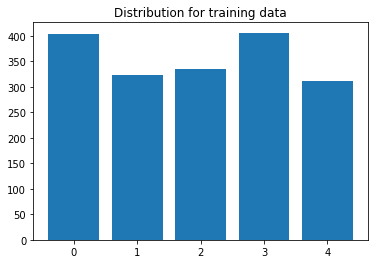

In [19]:
category, values = np.unique(train['label'].values, return_counts=True) #checking distribution
plt.title("Distribution for training data")
plt.bar(category,values)

<BarContainer object of 5 artists>

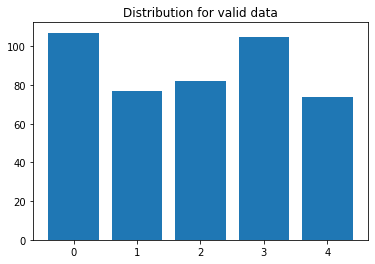

In [20]:
category, values = np.unique(test['label'].values, return_counts=True)
plt.title("Distribution for valid data")
plt.bar(category,values)

In [21]:
train.to_csv('/home/edshkim98/nlp/classification/train.csv', index=False)
test.to_csv('/home/edshkim98/nlp/classification/valid.csv', index=False)
train2, test2 = train.copy(), test.copy()

In [22]:
d = pd.read_csv('train.csv')
d

,label,text
0,4,Stars pay tribute to actor Davis Hollywood sta...
1,2,Cherie accused of attacking Bush Cherie Blair ...
2,1,Half-Life 2 sweeps Bafta awards PC first perso...
3,3,Roddick into San Jose final Andy Roddick will ...
4,1,PC photo printers challenge pros Home printed ...
...,...,...
1775,2,Blair backs 'pre-election budget' Tony Blair h...
1776,3,Johnson accuses British sprinters Former Olymp...
1777,0,Italy to get economic action plan Italian Prim...
1778,2,"Nat Insurance to rise, say Tories National Ins..."


In [23]:
d['text'].iloc[0]

'Stars pay tribute to actor Davis Hollywood stars including Spike Lee, Burt Reynolds and Oscar nominee Alan Alda have paid tribute to actor Ossie Davis at a funeral in New York. Veteran star Ossie Davis, a well-known civil rights activist, died in Miami at the age of 87 on 4 February 2005. Friends and family, including actress Ruby Dee his wife of 56 years, gathered at the Riverside Church on Saturday. Also present at the service was former US president Bill Clinton and singer Harry Belafonte, who gave the eulogy. "He would have been a very good president of the United States," said Mr Clinton. "Like most of you here, he gave more to me than I gave to him." The 87-year-old was found dead last weekend in his hotel room in Florida, where he was making a film. Police said that he appeared to have died of natural causes.'

In [24]:
# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import spacy
#spacy_en = spacy.load('en_core_web_sm')

In [25]:
# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('text', text_field)]

# # TabularDataset
# train_data, valid_data = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv',
#                                           format='CSV', fields=fields, skip_header=True)


/home/edshkim98/env/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [26]:
sample = pd.DataFrame({"label": [i[1] for i in summaries_data], "text": [i[0] for i in summaries_data]})
sample['text'] = sample['text'].apply(trim_string)
sample.to_csv("sample.csv", index=False)

In [27]:
# TabularDataset
train_data, valid_data,sample_data = TabularDataset.splits(path=source_folder, train='train.csv', validation='valid.csv', test='sample.csv'
                                          ,format='CSV', fields=fields, skip_header=True)
# Iterators
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_iter = BucketIterator(train_data, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid_data, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
sample_iter = BucketIterator(sample_data, batch_size=16, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train_data, min_freq=3)

/home/edshkim98/env/lib/python3.7/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/edshkim98/env/lib/python3.7/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/home/edshkim98/env/lib/python3.7/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further informat

In [28]:
next(iter(sample_iter))

/home/edshkim98/env/lib/python3.7/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)



[torchtext.data.batch.Batch of size 16]
	[.label]:[torch.cuda.FloatTensor of size 16 (GPU 0)]
	[.text]:('[torch.cuda.LongTensor of size 16x49 (GPU 0)]', '[torch.cuda.LongTensor of size 16 (GPU 0)]')

In [29]:
len(text_field.vocab)

9561

In [30]:
class LSTM(nn.Module):

    def __init__(self, dimension=256):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.2)

        self.fc = nn.Linear(2*dimension, 5)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        out = self.fc(text_fea)
        return out
    
class LSTM2(nn.Module):

    def __init__(self, dimension=256):
        super(LSTM2, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=False)
        self.drop = nn.Dropout(p=0.2)

        self.fc = nn.Linear(dimension, 5)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        packed_input = pack_padded_sequence(text_emb, text_len.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)
        out = self.fc(text_fea)
        return out

In [31]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer, device):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [32]:
# Training Function

def train(model,
          optimizer,
          criterion = nn.CrossEntropyLoss(),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 10,
          eval_every = len(train_iter),
          file_path = source_folder+'/pretrained/',
          best_valid_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (text, text_len)), _ in train_loader:           
            labels = labels.long().to(device)
            titletext = text.to(device)
            titletext_len = text_len.to(device)
            output = model(titletext, titletext_len)
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():
                    
                  # validation loop
                    for (labels, (text, text_len)), _ in valid_loader:
                        labels = labels.long().to(device)
                        titletext = text.to(device)
                        titletext_len = text_len.to(device)
                        output = model(titletext, titletext_len)

                        loss = criterion(output, labels)
                        valid_running_loss += loss.item()
                        _, predicted = torch.max(output, 1)

                print(predicted)
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_valid_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

In [33]:
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.train()

LSTM(
  (embedding): Embedding(9561, 300)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (drop): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=5, bias=True)
)

In [34]:
train(model=model, optimizer=optimizer, num_epochs=20)


tensor([2, 3, 0, 3, 0, 2, 3, 0, 0, 3, 0, 3, 0], device='cuda:0')
Epoch [1/20], Step [112/2240], Train Loss: 1.5932, Valid Loss: 1.5704
Model saved to ==> /home/edshkim98/nlp/classification//pretrained//model.pt
Model saved to ==> /home/edshkim98/nlp/classification//pretrained//metrics.pt
tensor([2, 3, 2, 2, 2, 2, 3, 0, 0, 3, 0, 3, 0], device='cuda:0')
Epoch [2/20], Step [224/2240], Train Loss: 1.5113, Valid Loss: 1.5261
Model saved to ==> /home/edshkim98/nlp/classification//pretrained//model.pt
Model saved to ==> /home/edshkim98/nlp/classification//pretrained//metrics.pt
tensor([2, 3, 2, 2, 2, 2, 3, 0, 0, 3, 0, 3, 0], device='cuda:0')
Epoch [3/20], Step [336/2240], Train Loss: 1.4172, Valid Loss: 1.4622
Model saved to ==> /home/edshkim98/nlp/classification//pretrained//model.pt
Model saved to ==> /home/edshkim98/nlp/classification//pretrained//metrics.pt
tensor([2, 1, 0, 1, 3, 2, 3, 0, 0, 2, 0, 3, 0], device='cuda:0')
Epoch [4/20], Step [448/2240], Train Loss: 1.2623, Valid Loss: 1.289

Model loaded from <== /home/edshkim98/nlp/classification/pretrained/metrics.pt


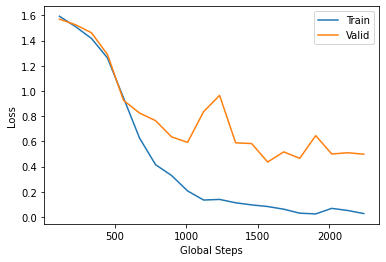

In [35]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

Model loaded from <== /home/edshkim98/nlp/classification/pretrained/model.pt


/home/edshkim98/env/lib/python3.7/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Classification Report:
              precision    recall  f1-score   support

           0     0.9130    0.7850    0.8442       107
           1     0.8857    0.8052    0.8435        77
           2     0.8295    0.8902    0.8588        82
           3     0.8860    0.9619    0.9224       105
           4     0.7654    0.8378    0.8000        74

    accuracy                         0.8584       445
   macro avg     0.8559    0.8560    0.8538       445
weighted avg     0.8620    0.8584    0.8579       445



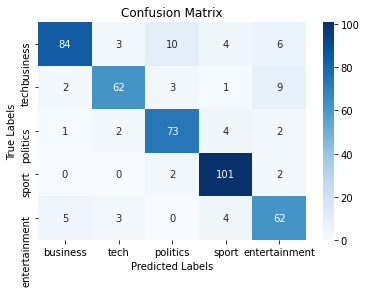

In [38]:
# Evaluation Function

def evaluate(model, test_loader, version='title', threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (text, text_len)), _ in test_loader:           
            labels = labels.long().to(device)
            titletext = text.to(device)
            titletext_len = text_len.to(device)
            output = model(titletext, titletext_len)

            _, predicted = torch.max(output, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, digits=4))
    
    cm = confusion_matrix(y_true, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['business', 'tech', 'politics','sport','entertainment'])
    ax.yaxis.set_ticklabels(['business', 'tech', 'politics','sport','entertainment'])
    
    
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer,device=device)
evaluate(best_model, valid_iter)

In [37]:
labels = {"business":0,"tech":1, "politics":2, "sport":3, "entertainment":4}

Testing in cpu

In [35]:
def test_single(model, test_loader):
    labels_dict = {0:"business",1:"tech", 2:"politics", 3:"sport", 4:"entertainment"}
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (text, text_len)), _ in test_loader:           
            labels = labels.long()#.to(device)
            titletext = text#.to(device)
            titletext_len = text_len#.to(device)
            output = model(titletext, titletext_len)

            _, predicted = torch.max(output, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(labels.tolist())
    print(labels_dict[int(predicted)])
    
def test_whole(model, test_loader, device):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (text, text_len)), _ in test_loader:           
            labels = labels.long().to(device)
            titletext = text.to(device)
            titletext_len = text_len.to(device)
            output = model(titletext, titletext_len)

            _, predicted = torch.max(output, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(labels.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['business', 'tech', 'politics','sport','entertainment'])
    ax.yaxis.set_ticklabels(['business', 'tech', 'politics','sport','entertainment'])

In [36]:
best_model = LSTM().to(device)
load_checkpoint(destination_folder + '/model.pt', best_model, optimizer,device=device)
best_model

Model loaded from <== /home/edshkim98/nlp/classification/pretrained/model.pt


LSTM(
  (embedding): Embedding(9561, 300)
  (lstm): LSTM(300, 256, batch_first=True, bidirectional=True)
  (drop): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=512, out_features=5, bias=True)
)

Classification Report:
              precision    recall  f1-score   support

           0     0.8164    0.7412    0.7770       510
           1     0.7046    0.8030    0.7506       401
           2     0.7545    0.7962    0.7748       417
           3     0.8797    0.8297    0.8540       511
           4     0.7441    0.7383    0.7412       386

    accuracy                         0.7825      2225
   macro avg     0.7799    0.7817    0.7795      2225
weighted avg     0.7867    0.7825    0.7833      2225



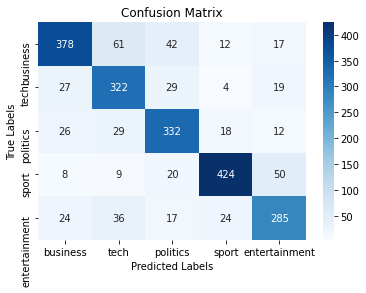

In [37]:
test_whole(best_model, sample_iter,device=device)